In [19]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
import re
%matplotlib inline

In [20]:
os.chdir("C:/Users/Ajantha/Documents/courses/data_science/data_analysis/datasets/nflstatistics/")

## Read Running Backs' Career Stats
Read career long data of running backs.

In [21]:
rushers_original = pd.read_csv("Career_Stats_Rushing.csv")
rushers_original = rushers_original[rushers_original.Position == 'RB']

Let's look at a sample of 5 of those players

In [22]:
rushers_original.head(5)

,Player Id,Name,Position,Year,Team,Games Played,Rushing Attempts,Rushing Attempts Per Game,Rushing Yards,Yards Per Carry,Rushing Yards Per Game,Rushing TDs,Longest Rushing Run,Rushing First Downs,Percentage of Rushing First Downs,Rushing More Than 20 Yards,Rushing More Than 40 Yards,Fumbles
138,kenyandrake/2555230,"Drake, Kenyan",RB,2016,Miami Dolphins,16,33,2.1,179,5.4,11.2,2,45T,9,27.3,1,1,0
292,darylrichardson/2534789,"Richardson, Daryl",RB,2016,Jacksonville Jaguars,0,--,0.0,--,--,--,--,--,--,--,--,--,--
293,darylrichardson/2534789,"Richardson, Daryl",RB,2016,Pittsburgh Steelers,3,2,0.7,7,3.5,2.3,0,6,0,0.0,0,0,0
294,darylrichardson/2534789,"Richardson, Daryl",RB,2015,Cleveland Browns,0,--,0.0,--,--,--,--,--,--,--,--,--,--
295,darylrichardson/2534789,"Richardson, Daryl",RB,2013,St. Louis Rams,8,69,8.6,215,3.1,26.9,0,14,12,17.4,0,0,0


The dataset offers the following information:

In [23]:
rushers_original.columns.tolist()

['Player Id',
 'Name',
 'Position',
 'Year',
 'Team',
 'Games Played',
 'Rushing Attempts',
 'Rushing Attempts Per Game',
 'Rushing Yards',
 'Yards Per Carry',
 'Rushing Yards Per Game',
 'Rushing TDs',
 'Longest Rushing Run',
 'Rushing First Downs',
 'Percentage of Rushing First Downs',
 'Rushing More Than 20 Yards',
 'Rushing More Than 40 Yards',
 'Fumbles']

## First things first...
Based on the information we have, I'd like to first answer some basic questions:

1. Who are some of the explosive runners who gain more than 40 yards per play frequently
2. Who have ball protection issues
3. High volume rushers
4. High efficiency rushers - YPC and TDs
5. Who missed the most games - fragile players
6. Most prolific rushers - focus on total yards, volume (bellcow), yards per carry
7. Trusted players to pick up first downs

### High volume rushers
To determine high volume rushers, let's slice the original data frame based on rushing attempts per game, dropping all instances that have zero attempts

In [24]:
non_zero_attempts = rushers_original["Rushing Attempts Per Game"].sort_values(ascending=False) != 0.0
rushers = rushers_original.loc[non_zero_attempts]

Group the remaining data by rusher to look at this information categorically


In [25]:
rushers_grouped = rushers.groupby(by="Name")
average_rushing_attempts_per_game = rushers_grouped["Rushing Attempts Per Game"].agg('median').sort_values(ascending=False)

Text(0,0.5,'Average Rushing Volume')

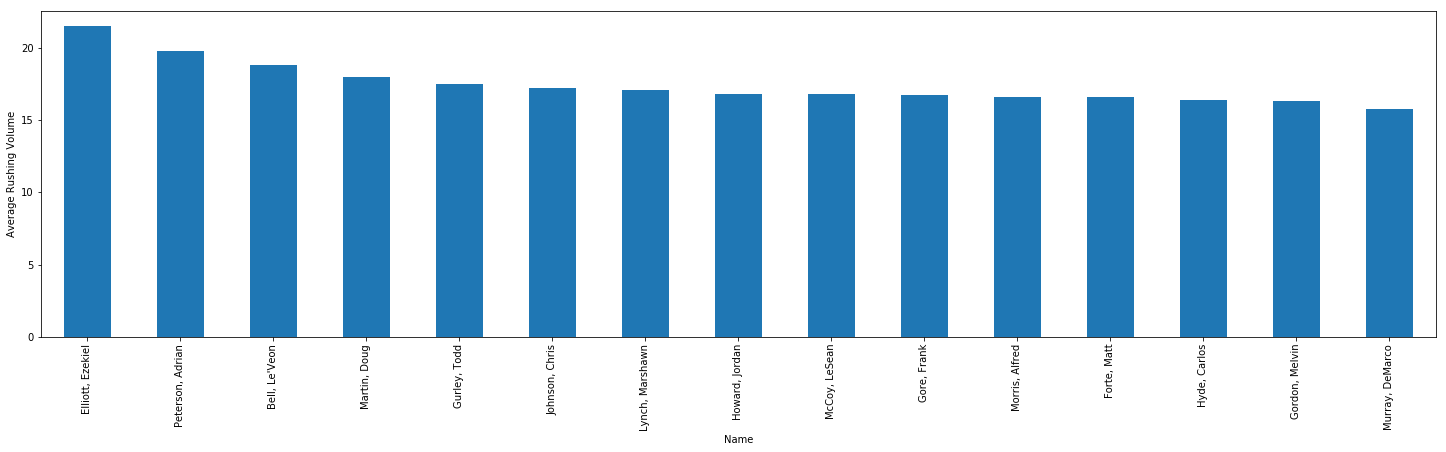

In [26]:
# Plot information about players who had at least 15 carries per game on an average. The idea is that if a rusher has fewer 
# than 15 attempts per game, it would even qualify as "high volume"
plt.figure(figsize=(25, 6))
high_volume_rushers = average_rushing_attempts_per_game[average_rushing_attempts_per_game >= 15]
high_volume_rushers.plot.bar()
plt.ylabel("Average Rushing Volume")

While this gives a general idea of high volume backs, it doesn't take into account other important factors such as experience, spread of the volume (are there outlier seasons?), e.t.c. Let's at least add experience to the analysis to add some weight to any take aways


In [27]:
data = []
for rusher in high_volume_rushers.index.tolist():
    data.append(rushers_grouped.get_group(rusher).shape[0])
rusher_experience = pd.Series(data, high_volume_rushers.index)
rusher_experience.sort_values(ascending=False, inplace=True)

Text(0,0.5,'Experience')

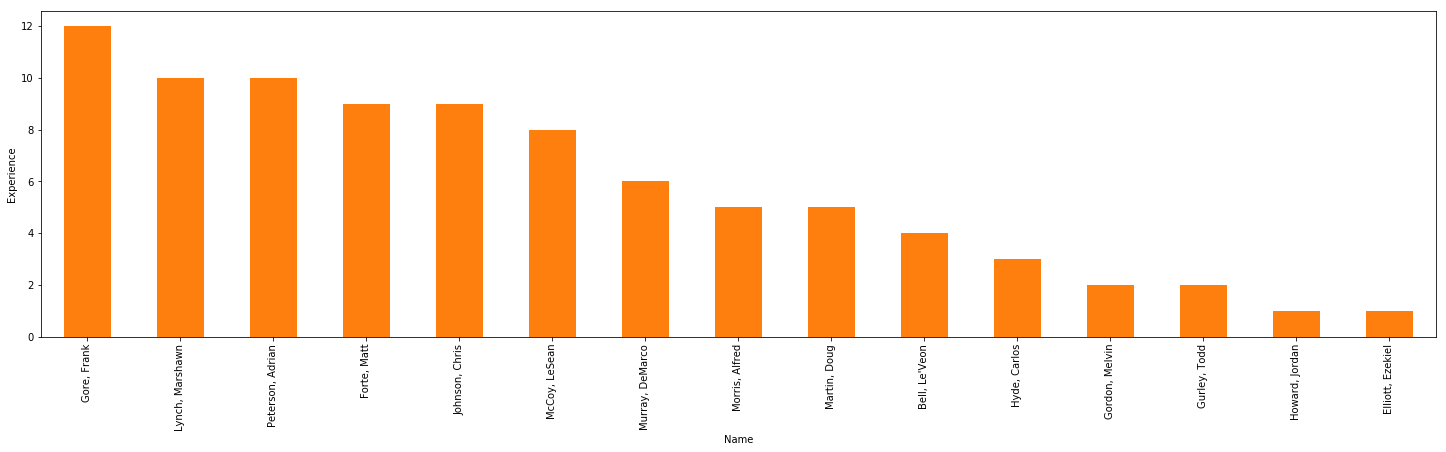

In [28]:
plt.figure(figsize=(25, 6))
rusher_experience.plot.bar(color='C1')
plt.ylabel("Experience")

In [29]:
current_star_rushers_by_volume = rusher_experience[rusher_experience <= 8]
my_rushers = pd.DataFrame(current_star_rushers_by_volume.index)
my_rushers["Experience"] = current_star_rushers_by_volume.values
my_rushers["Average Rushing Volume"] = high_volume_rushers[my_rushers.Name].values
my_rushers.sort_values(by="Average Rushing Volume", ascending=False)

,Name,Experience,Average Rushing Volume
9,"Elliott, Ezekiel",1,21.5
4,"Bell, Le'Veon",4,18.8
3,"Martin, Doug",5,18.0
7,"Gurley, Todd",2,17.5
8,"Howard, Jordan",1,16.8
0,"McCoy, LeSean",8,16.8
2,"Morris, Alfred",5,16.6
5,"Hyde, Carlos",3,16.4
6,"Gordon, Melvin",2,16.3
1,"Murray, DeMarco",6,15.8


### Ball Handling

In [30]:
rushers_original.Fumbles
mask = rushers_original["Fumbles"].sort_values(ascending=False) != "--"
rushers = rushers_original.loc[mask]
rushers["Fumbles"] = pd.to_numeric(rushers["Fumbles"])
rushers_grouped = rushers.groupby(by="Name")
# rusher_fumbles_record = rushers_grouped["Fumbles"].agg('sum').sort_values(ascending=False)

C:\Users\Ajantha\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [31]:
rusher_fumbles = rushers_grouped['Fumbles'].agg('sum').sort_values(ascending=False)

Text(0,0.5,'Fumbles')

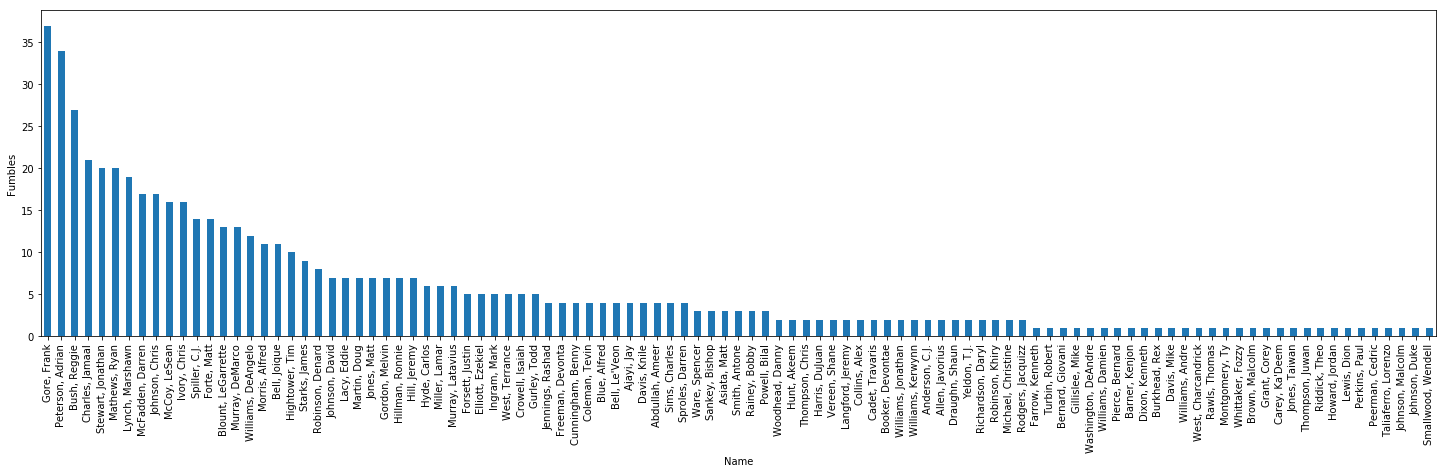

In [32]:
plt.figure(figsize=(25, 6))
rusher_fumbles[rusher_fumbles > 0].plot.bar()
plt.ylabel("Fumbles")

### Top 10 ball fumblers

In [33]:
pd.DataFrame(rusher_fumbles.head(10))

,Fumbles
Name,
"Gore, Frank",37
"Peterson, Adrian",34
"Bush, Reggie",27
"Charles, Jamaal",21
"Stewart, Jonathan",20
"Mathews, Ryan",20
"Lynch, Marshawn",19
"McFadden, Darren",17
"Johnson, Chris",17


In [34]:
num_fumbles = []
for rusher in my_rushers.Name:
    num_fumbles.append(rusher_fumbles[rusher_fumbles.index == rusher].iloc[0])
    
my_rushers["Fumbles"] = num_fumbles
my_rushers["Fumbles Per Season"] = my_rushers.Fumbles/my_rushers.Experience

In [35]:
my_rushers.sort_values(by=["Experience", "Average Rushing Volume"], ascending=False)

,Name,Experience,Average Rushing Volume,Fumbles,Fumbles Per Season
0,"McCoy, LeSean",8,16.8,16,2.000000
1,"Murray, DeMarco",6,15.8,13,2.166667
3,"Martin, Doug",5,18.0,7,1.400000
2,"Morris, Alfred",5,16.6,11,2.200000
4,"Bell, Le'Veon",4,18.8,4,1.000000
5,"Hyde, Carlos",3,16.4,6,2.000000
7,"Gurley, Todd",2,17.5,5,2.500000
6,"Gordon, Melvin",2,16.3,7,3.500000
9,"Elliott, Ezekiel",1,21.5,5,5.000000
8,"Howard, Jordan",1,16.8,1,1.000000


## Insights & Predictions
1. Which teams lean towards bellcow vs RBBC approach

In [38]:
rbgroup = rushers_original.groupby(by=["Name", "Year"])
df = pd.DataFrame(rbgroup["Rushing Yards"].agg(sum))
df.reset_index(inplace=True)
rookieyearmask = df.Name.searchsorted(df.Name.unique())
df2 = df.iloc[rookieyearmask]
df2.sort_values(by="Rushing Yards", ascending=False)
aa = df2["Rushing Yards"]
df2 = df2[~aa.str.contains('-')]
ry = df2["Rushing Yards"].str.replace(",", "")
df2["Rushing Yards"] = pd.to_numeric(ry)
df2.sort_values(by="Rushing Yards", ascending=False, inplace=True)
df2.set_index("Name")

,Year,Rushing Yards
Name,,
"Elliott, Ezekiel",2016,1631
"Morris, Alfred",2012,1613
"Martin, Doug",2012,1454
"Peterson, Adrian",2007,1341
"Howard, Jordan",2016,1313
"Forte, Matt",2008,1238
"Johnson, Chris",2008,1228
"Lacy, Eddie",2013,1178
"Hill, Jeremy",2014,1124


In [39]:
df2.set_index(df2.index.sort_values(), inplace=True)
df2[df2["Rushing Yards"] > 1000]

,Name,Year,Rushing Yards
0,"Elliott, Ezekiel",2016,1631
2,"Morris, Alfred",2012,1613
4,"Martin, Doug",2012,1454
6,"Peterson, Adrian",2007,1341
10,"Howard, Jordan",2016,1313
12,"Forte, Matt",2008,1238
23,"Johnson, Chris",2008,1228
24,"Lacy, Eddie",2013,1178
34,"Hill, Jeremy",2014,1124
38,"Lynch, Marshawn",2007,1115


In [40]:
df2.set_index(["Name", "Year"], inplace=True)

[Text(0,0,"('Elliott, Ezekiel', 2016)"),
 Text(0,0,"('Morris, Alfred', 2012)"),
 Text(0,0,"('Martin, Doug', 2012)"),
 Text(0,0,"('Peterson, Adrian', 2007)"),
 Text(0,0,"('Howard, Jordan', 2016)"),
 Text(0,0,"('Forte, Matt', 2008)"),
 Text(0,0,"('Johnson, Chris', 2008)"),
 Text(0,0,"('Lacy, Eddie', 2013)"),
 Text(0,0,"('Hill, Jeremy', 2014)"),
 Text(0,0,"('Lynch, Marshawn', 2007)"),
 Text(0,0,"('Gurley, Todd', 2015)"),
 Text(0,0,"('Blount, LeGarrette', 2010)")]

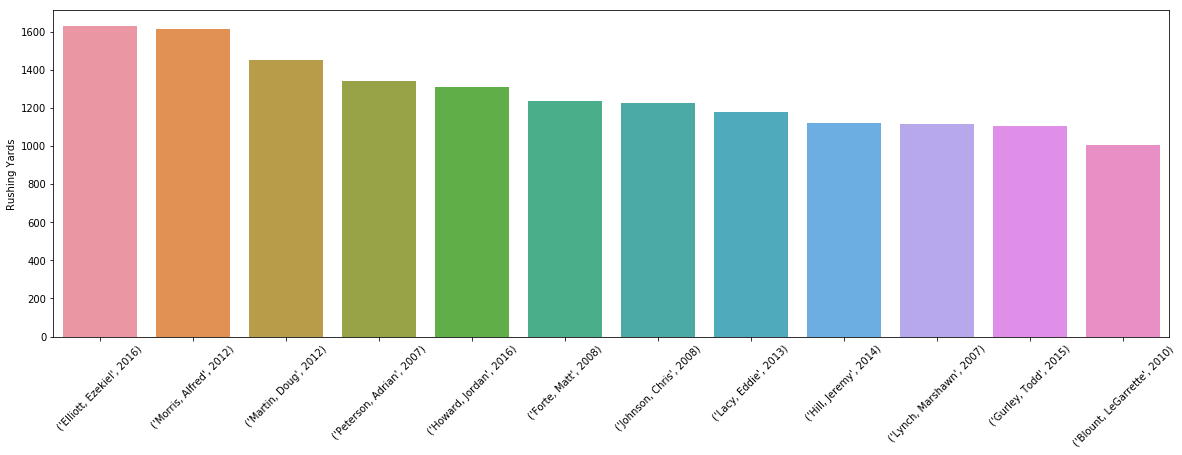

In [41]:
plt.figure(figsize=(20,6))
sp = sns.barplot(data=df2.head(12), x = df2.head(12).index, y = "Rushing Yards")
sp.set_xticklabels(df2.head(12).index, rotation=45)

In [42]:
df2

,,Rushing Yards
Name,Year,
"Elliott, Ezekiel",2016,1631
"Morris, Alfred",2012,1613
"Martin, Doug",2012,1454
"Peterson, Adrian",2007,1341
"Howard, Jordan",2016,1313
"Forte, Matt",2008,1238
"Johnson, Chris",2008,1228
"Lacy, Eddie",2013,1178
"Hill, Jeremy",2014,1124


In [43]:
df2.head(12).describe()

,Rushing Yards
count,12.000000
mean,1279.000000
std,200.091343
min,1007.000000
25%,1121.750000
50%,1233.000000
75%,1369.250000
max,1631.000000


In [46]:
# Adrian Peterson
peterson = rushers_original[rushers_original.Name == "Peterson, Adrian"]
peterson["Games Played"]

1284     3
1285    16
1286     1
1287    14
1288    16
1289    12
1290    15
1291    16
1292    16
1293    14
Name: Games Played, dtype: int64

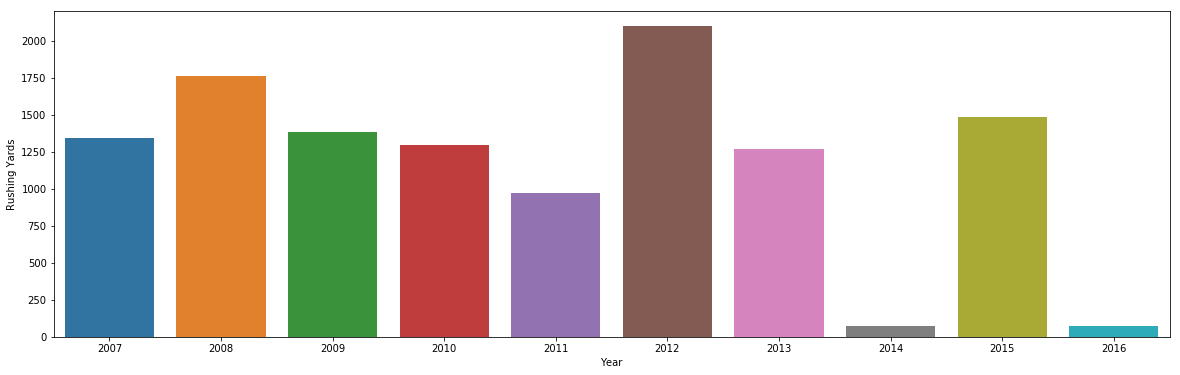

In [47]:
aa = peterson["Rushing Yards"]
peterson = peterson[~aa.str.contains('-')]

ry = peterson["Rushing Yards"].str.replace(",", "")

peterson["Rushing Yards"] = pd.to_numeric(ry)

plt.figure(figsize=(20,6))
sp = sns.barplot(data=peterson, x = peterson.Year, y = "Rushing Yards")

In [48]:
# Matt Forte
forte = rushers_original[rushers_original.Name == "Forte, Matt"]
forte.Team

14742    New York Jets
14743    Chicago Bears
14744    Chicago Bears
14745    Chicago Bears
14746    Chicago Bears
14747    Chicago Bears
14748    Chicago Bears
14749    Chicago Bears
14750    Chicago Bears
Name: Team, dtype: object

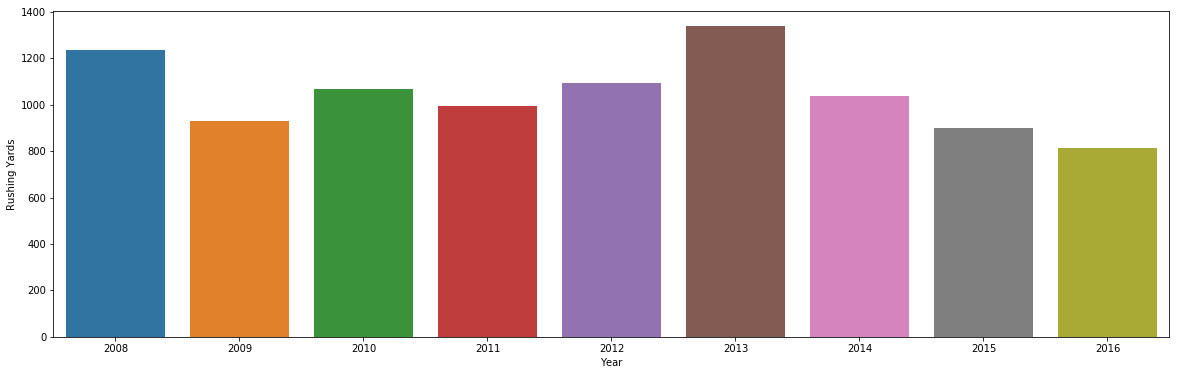

In [49]:
aa = forte["Rushing Yards"]
forte = forte[~aa.str.contains('-')]

ry = forte["Rushing Yards"].str.replace(",", "")

forte["Rushing Yards"] = pd.to_numeric(ry)

plt.figure(figsize=(20,6))
sp = sns.barplot(data=forte, x = forte.Year, y = "Rushing Yards")

In [51]:
# Chris Johnson
c2k = rushers_original[rushers_original.Name == "Johnson, Chris"]
c2k.Team

9877    Arizona Cardinals
9878    Arizona Cardinals
9879        New York Jets
9880     Tennessee Titans
9881     Tennessee Titans
9882     Tennessee Titans
9883     Tennessee Titans
9884     Tennessee Titans
9885     Tennessee Titans
Name: Team, dtype: object

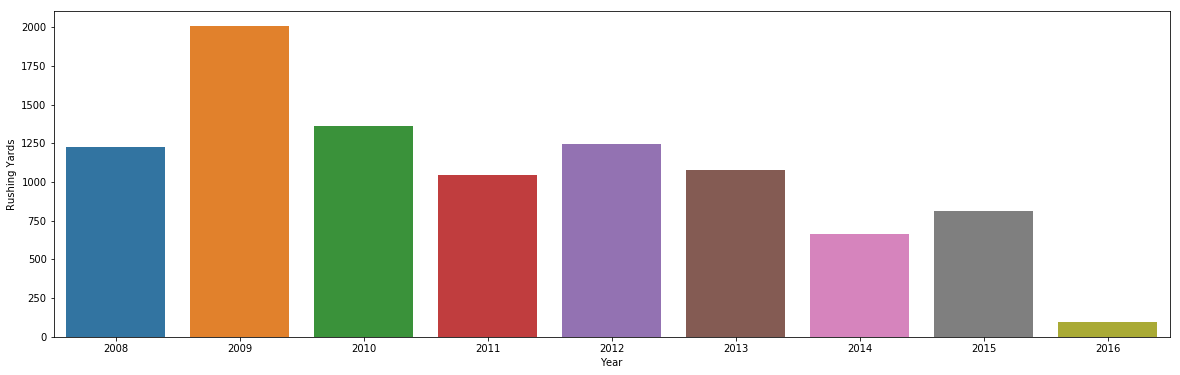

In [52]:
aa = c2k["Rushing Yards"]
c2k = c2k[~aa.str.contains('-')]

ry = c2k["Rushing Yards"].str.replace(",", "")

c2k["Rushing Yards"] = pd.to_numeric(ry)

ax = plt.figure(figsize=(20,6))
sp = sns.barplot(data=c2k, x = c2k.Year, y = "Rushing Yards")
# sns.regplot(x=c2k.Year, y=c2k["Rushing Yards"], ax=ax)

In [54]:
# Marshawn Lynch
beast = rushers_original[rushers_original.Name == "Lynch, Marshawn"]
beast.Team

6683    Seattle Seahawks
6684    Seattle Seahawks
6685    Seattle Seahawks
6686    Seattle Seahawks
6687    Seattle Seahawks
6688    Seattle Seahawks
6689       Buffalo Bills
6690       Buffalo Bills
6691       Buffalo Bills
6692       Buffalo Bills
Name: Team, dtype: object

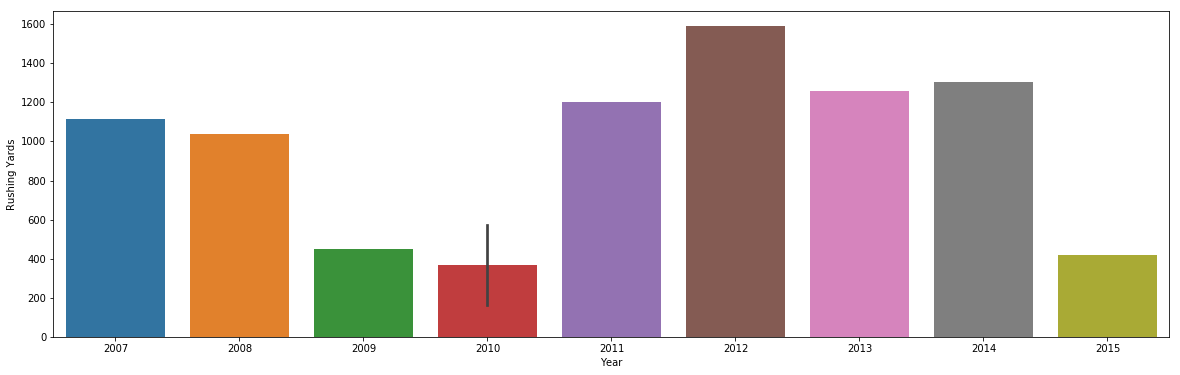

In [55]:
aa = beast["Rushing Yards"]
beast = beast[~aa.str.contains('-')]

ry = beast["Rushing Yards"].str.replace(",", "")

beast["Rushing Yards"] = pd.to_numeric(ry)

plt.figure(figsize=(20,6))
sp = sns.barplot(data=beast, x = beast.Year, y = "Rushing Yards")

In [56]:
# which running backs are into their 6th season
df3 = pd.read_csv("Basic_Stats.csv")
df3 = df3[df3.Position == "RB"]
df3 = df3[df3.Experience == "5th season"]
df3.Name.sort_values()

15049        Anderson, C.J.
1111          Bell, Le'Veon
15470      Bernard, Giovani
15167         Burkhead, Rex
10726     Cunningham, Benny
12404          Davis, Knile
9369       Grimes, Jonathan
11000           Lacy, Eddie
11059    Michael, Christine
11495      Murray, Latavius
3515        Reynolds, Chase
9804          Riddick, Theo
8164       Robinson, Denard
12698       Taylor, Stepfan
8745         Todman, Jordan
6084       Whittaker, Fozzy
Name: Name, dtype: object

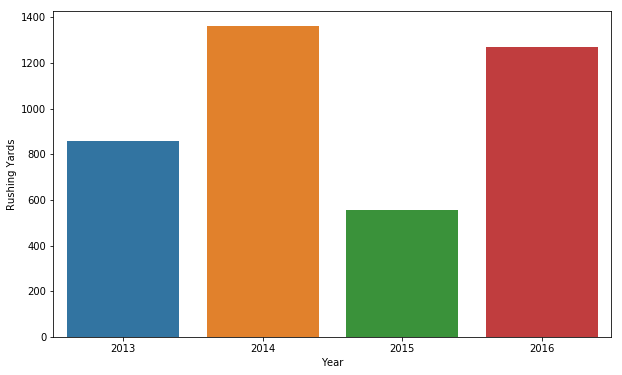

In [57]:
# LeVeon Bell
bell = rushers_original[rushers_original.Name == "Bell, Le'Veon"]
bell.Team
aa = bell["Rushing Yards"]
bell = bell[~aa.str.contains('-')]

ry = bell["Rushing Yards"].str.replace(",", "")

bell["Rushing Yards"] = pd.to_numeric(ry)

plt.figure(figsize=(10,6))
sp = sns.barplot(data=bell, x = bell.Year, y = "Rushing Yards")

In [58]:
bell["Games Played"]

989    12
990     6
991    16
992    13
Name: Games Played, dtype: int64